# Diplodatos Kaggle Competition

We present this peace of code to create the baseline for the competition, and as an example of how to deal with these kind of problems. The main goals are that you:

1. Learn
1. Try different models and see which one fits the best the given data
1. Get a higher score than the given one in the current baseline example
1. Try to get the highest score in the class :)

El objetivo es intentar predecir los tipos de viajes de compras al supermercado realizados por los clientes. Estos tipos están codificados en el dataset original.

Se tiene que superar el puntaje del baseline.

Para esta competencia, tiene la tarea de clasificar los tipos de viajes de compras en función de los artículos que compraron los clientes. Para dar algunos ejemplos hipotéticos de tipos de viajes: un cliente puede hacer un pequeño viaje diario a cenar, un gran viaje semanal de comestibles, un viaje para comprar regalos para las próximas vacaciones o un viaje de temporada para comprar ropa.

Walmart ha categorizado los viajes contenidos en estos datos en 38 tipos distintos utilizando un método propio aplicado a un conjunto extendido de datos. Tiene el desafío de recrear esta categorización / agrupación con un conjunto más limitado de características. Esto podría proporcionar formas nuevas y más sólidas de categorizar viajes.

El conjunto de formación (train.csv) contiene una gran cantidad de visitas de clientes con TripType incluido. Debe predecir el TripType para cada visita de un cliente en el conjunto de prueba (test.csv). Cada visita solo puede tener un TripType. No se le proporcionará más información de la que se proporciona en los datos (por ejemplo, lo que representan los TripTypes o más información del producto).

**Data fields**

- TripType: un ID categórico que representa el tipo de viaje de compras que realizó el cliente. Ésta es la verdad fundamental que está prediciendo. - TripType_999 es una categoría “otra”.
- VisitNumber: un ID correspondiente a un solo viaje de un solo cliente
- Weekday: el día de la semana del viaje.
- Upc: el número UPC del producto comprado
- ScanCount: el número del artículo determinado que se compró. Un valor negativo indica una devolución de producto.
- DepartmentDescription: una descripción de alto nivel del departamento del artículo
- FinelineNumber: una categoría más refinada para cada uno de los productos, creada por Walmart

_**TripType** es la columna que debemos predecir. Esa columna no está presente en el conjunto de prueba_


In [ ]:
# instalamos category_encoders
!pip install category_encoders

     |████████████████████████████████| 81kB 4.2MB/s 


In [ ]:
# Import the required packages
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

# Agremamos librerias
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import category_encoders as ce

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Read the *original* dataset...

In [ ]:
URL_TRAIN = 'https://raw.githubusercontent.com/DiploDatos/AprendizajeSupervisado/master/practico/data/train.csv'
URL_TEST = 'https://raw.githubusercontent.com/DiploDatos/AprendizajeSupervisado/master/practico/data/test.csv'

In [ ]:
original_df = pd.read_csv(URL_TRAIN)

In [ ]:
original_df.columns

Index(['TripType', 'VisitNumber', 'Weekday', 'Upc', 'ScanCount',
       'DepartmentDescription', 'FinelineNumber'],
      dtype='object')

In [ ]:
original_df.describe()

,TripType,VisitNumber,Upc,ScanCount,FinelineNumber
count,453411.000000,453411.000000,4.505590e+05,453411.000000,450559.000000
mean,58.027039,95909.846115,3.075243e+10,1.108584,3727.366554
std,155.973370,55399.801147,9.163940e+10,0.707029,2779.958546
min,3.000000,5.000000,8.340000e+02,-10.000000,0.000000
25%,27.000000,49390.000000,3.400004e+09,1.000000,1404.000000
50%,39.000000,96781.000000,7.056082e+09,1.000000,3352.000000
75%,40.000000,143930.000000,3.013201e+10,1.000000,5501.000000
max,999.000000,191347.000000,9.789707e+11,71.000000,9998.000000


In [ ]:
original_df.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,8,9,Friday,1.070081e+09,1,IMPULSE MERCHANDISE,115.0
2,8,9,Friday,3.107000e+03,1,PRODUCE,103.0
3,8,9,Friday,4.011000e+03,1,PRODUCE,5501.0
4,8,10,Friday,6.414410e+09,1,DSD GROCERY,2008.0


Looking into the columns values...

In [ ]:
set(original_df.Weekday)

{'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday'}

In [ ]:
set(original_df.DepartmentDescription)

{'1-HR PHOTO',
 'ACCESSORIES',
 'AUTOMOTIVE',
 'BAKERY',
 'BATH AND SHOWER',
 'BEAUTY',
 'BEDDING',
 'BOOKS AND MAGAZINES',
 'BOYS WEAR',
 'BRAS & SHAPEWEAR',
 'CAMERAS AND SUPPLIES',
 'CANDY, TOBACCO, COOKIES',
 'CELEBRATION',
 'COMM BREAD',
 'CONCEPT STORES',
 'COOK AND DINE',
 'DAIRY',
 'DSD GROCERY',
 'ELECTRONICS',
 'FABRICS AND CRAFTS',
 'FINANCIAL SERVICES',
 'FROZEN FOODS',
 'FURNITURE',
 'GIRLS WEAR, 4-6X  AND 7-14',
 'GROCERY DRY GOODS',
 'HARDWARE',
 'HEALTH AND BEAUTY AIDS',
 'HOME DECOR',
 'HOME MANAGEMENT',
 'HORTICULTURE AND ACCESS',
 'HOUSEHOLD CHEMICALS/SUPP',
 'HOUSEHOLD PAPER GOODS',
 'IMPULSE MERCHANDISE',
 'INFANT APPAREL',
 'INFANT CONSUMABLE HARDLINES',
 'JEWELRY AND SUNGLASSES',
 'LADIES SOCKS',
 'LADIESWEAR',
 'LARGE HOUSEHOLD GOODS',
 'LAWN AND GARDEN',
 'LIQUOR,WINE,BEER',
 'MEAT - FRESH & FROZEN',
 'MEDIA AND GAMING',
 'MENS WEAR',
 'MENSWEAR',
 'OFFICE SUPPLIES',
 'OPTICAL - FRAMES',
 'OPTICAL - LENSES',
 'OTHER DEPARTMENTS',
 'PAINT AND ACCESSORIES',
 'PER

There are `nan`s in the column, let us find them...

In [ ]:
original_df[original_df.DepartmentDescription.isna()]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
739,999,484,Friday,NaN,-2,NaN,NaN
740,999,484,Friday,NaN,-2,NaN,NaN
1292,32,845,Friday,NaN,1,NaN,NaN
1293,32,845,Friday,NaN,1,NaN,NaN
1577,40,1004,Friday,NaN,1,NaN,NaN
...,...,...,...,...,...,...,...
449840,40,190133,Sunday,NaN,1,NaN,NaN
450036,999,190182,Sunday,NaN,-1,NaN,NaN
450163,40,190230,Sunday,NaN,1,NaN,NaN
450361,39,190309,Sunday,NaN,1,NaN,NaN


When the description is NaN, then the Upc and FinelineNumber are both NaN?

In [ ]:
(original_df.DepartmentDescription.isna().sum(),
 (original_df.DepartmentDescription.isna() & original_df.Upc.isna() & original_df.FinelineNumber.isna()).sum())

(972, 972)

In [ ]:
original_df[original_df.Upc.isna()]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
739,999,484,Friday,NaN,-2,NaN,NaN
740,999,484,Friday,NaN,-2,NaN,NaN
900,5,585,Friday,NaN,1,PHARMACY RX,NaN
944,5,619,Friday,NaN,1,PHARMACY RX,NaN
945,5,619,Friday,NaN,1,PHARMACY RX,NaN
...,...,...,...,...,...,...,...
449840,40,190133,Sunday,NaN,1,NaN,NaN
450036,999,190182,Sunday,NaN,-1,NaN,NaN
450163,40,190230,Sunday,NaN,1,NaN,NaN
450361,39,190309,Sunday,NaN,1,NaN,NaN


But it may be the case that Upc is NaN but not the description...

In [ ]:
(original_df.Upc.isna().sum(),
 original_df.FinelineNumber.isna().sum(),
 (original_df.FinelineNumber.isna() & original_df.Upc.isna()).sum())

(2852, 2852, 2852)

Upc and FinelineNumber are both NaN at the same time

Our last step in this analysis is to see how balanced is the data...

In [ ]:
bins = set(original_df.TripType)

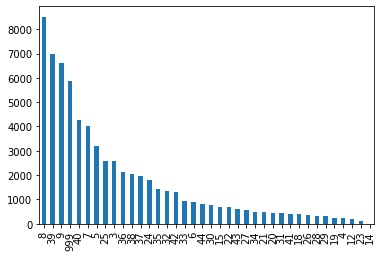

In [ ]:
# to count the TripType values, we have to group the visits by VisitNumber
original_df.groupby("VisitNumber").TripType.mean().value_counts().plot(kind='bar')

**Unbalanced!!!**

Create a function to load the datasets.

**Some important decisions made here**:
1. We will use one hot encoding for Weekday and DepartmentDescription. All transformations are applied to the training and testing datasets...
1. We are handling NaN's as another category. This may not be the best approach.
1. We may have multiple records for one single visit and the goal is to classify all those records the exact same way. Therefore, we will prepare the data in a way that all the information for a visit is in the same record.
1. Based on the last bullet, we will count the DepartmentDescription for all items acquired in the same visit.
1. We drop the Upc and FinelineNumber to simplify the process. You may use it as they have a lot of information (may be using one-hot encoding for them as well)

The following operations will be performed in a function. Anyway, we present them here so that we can see them in action:

First, we drop the columns. We include TripType as we are going to treat it differently:

In [ ]:
df = original_df.drop(["Upc", "FinelineNumber", "TripType"], axis=1)

In [ ]:
df

,VisitNumber,Weekday,ScanCount,DepartmentDescription
0,5,Friday,-1,FINANCIAL SERVICES
1,9,Friday,1,IMPULSE MERCHANDISE
2,9,Friday,1,PRODUCE
3,9,Friday,1,PRODUCE
4,10,Friday,1,DSD GROCERY
...,...,...,...,...
453406,191344,Sunday,1,BEAUTY
453407,191344,Sunday,1,WIRELESS
453408,191344,Sunday,1,BEAUTY
453409,191347,Sunday,1,DAIRY


Now, we create the dummy columns

In [ ]:
df = pd.get_dummies(df, columns=["DepartmentDescription"], dummy_na=True)

In [ ]:
df

,VisitNumber,Weekday,ScanCount,DepartmentDescription_1-HR PHOTO,DepartmentDescription_ACCESSORIES,DepartmentDescription_AUTOMOTIVE,DepartmentDescription_BAKERY,DepartmentDescription_BATH AND SHOWER,DepartmentDescription_BEAUTY,DepartmentDescription_BEDDING,DepartmentDescription_BOOKS AND MAGAZINES,DepartmentDescription_BOYS WEAR,DepartmentDescription_BRAS & SHAPEWEAR,DepartmentDescription_CAMERAS AND SUPPLIES,"DepartmentDescription_CANDY, TOBACCO, COOKIES",DepartmentDescription_CELEBRATION,DepartmentDescription_COMM BREAD,DepartmentDescription_CONCEPT STORES,DepartmentDescription_COOK AND DINE,DepartmentDescription_DAIRY,DepartmentDescription_DSD GROCERY,DepartmentDescription_ELECTRONICS,DepartmentDescription_FABRICS AND CRAFTS,DepartmentDescription_FINANCIAL SERVICES,DepartmentDescription_FROZEN FOODS,DepartmentDescription_FURNITURE,"DepartmentDescription_GIRLS WEAR, 4-6X AND 7-14",DepartmentDescription_GROCERY DRY GOODS,DepartmentDescription_HARDWARE,DepartmentDescription_HEALTH AND BEAUTY AIDS,DepartmentDescription_HOME DECOR,DepartmentDescription_HOME MANAGEMENT,DepartmentDescription_HORTICULTURE AND ACCESS,DepartmentDescription_HOUSEHOLD CHEMICALS/SUPP,DepartmentDescription_HOUSEHOLD PAPER GOODS,DepartmentDescription_IMPULSE MERCHANDISE,DepartmentDescription_INFANT APPAREL,DepartmentDescription_INFANT CONSUMABLE HARDLINES,DepartmentDescription_JEWELRY AND SUNGLASSES,DepartmentDescription_LADIES SOCKS,DepartmentDescription_LADIESWEAR,DepartmentDescription_LARGE HOUSEHOLD GOODS,DepartmentDescription_LAWN AND GARDEN,"DepartmentDescription_LIQUOR,WINE,BEER",DepartmentDescription_MEAT - FRESH & FROZEN,DepartmentDescription_MEDIA AND GAMING,DepartmentDescription_MENS WEAR,DepartmentDescription_MENSWEAR,DepartmentDescription_OFFICE SUPPLIES,DepartmentDescription_OPTICAL - FRAMES,DepartmentDescription_OPTICAL - LENSES,DepartmentDescription_OTHER DEPARTMENTS,DepartmentDescription_PAINT AND ACCESSORIES,DepartmentDescription_PERSONAL CARE,DepartmentDescription_PETS AND SUPPLIES,DepartmentDescription_PHARMACY OTC,DepartmentDescription_PHARMACY RX,DepartmentDescription_PLAYERS AND ELECTRONICS,DepartmentDescription_PLUS AND MATERNITY,DepartmentDescription_PRE PACKED DELI,DepartmentDescription_PRODUCE,DepartmentDescription_SEAFOOD,DepartmentDescription_SEASONAL,DepartmentDescription_SERVICE DELI,DepartmentDescription_SHEER HOSIERY,DepartmentDescription_SHOES,DepartmentDescription_SLEEPWEAR/FOUNDATIONS,DepartmentDescription_SPORTING GOODS,DepartmentDescription_SWIMWEAR/OUTERWEAR,DepartmentDescription_TOYS,DepartmentDescription_WIRELESS,DepartmentDescription_nan
0,5,Friday,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,Friday,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,9,Friday,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,9,Friday,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,10,Friday,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
453406,191344,Sunday,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
453407,191344,Sunday,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
453408,191344,Sunday,1,0,0,0,0,0

Now, we group by the VisitNumber and Weekday (they should be the same), and add all values for ScanCount, and the one-hot encoding of DepartmentDescriptioin

In [ ]:
df = df.groupby(["VisitNumber", "Weekday"], as_index=False).sum()

In [ ]:
df

,VisitNumber,Weekday,ScanCount,DepartmentDescription_1-HR PHOTO,DepartmentDescription_ACCESSORIES,DepartmentDescription_AUTOMOTIVE,DepartmentDescription_BAKERY,DepartmentDescription_BATH AND SHOWER,DepartmentDescription_BEAUTY,DepartmentDescription_BEDDING,DepartmentDescription_BOOKS AND MAGAZINES,DepartmentDescription_BOYS WEAR,DepartmentDescription_BRAS & SHAPEWEAR,DepartmentDescription_CAMERAS AND SUPPLIES,"DepartmentDescription_CANDY, TOBACCO, COOKIES",DepartmentDescription_CELEBRATION,DepartmentDescription_COMM BREAD,DepartmentDescription_CONCEPT STORES,DepartmentDescription_COOK AND DINE,DepartmentDescription_DAIRY,DepartmentDescription_DSD GROCERY,DepartmentDescription_ELECTRONICS,DepartmentDescription_FABRICS AND CRAFTS,DepartmentDescription_FINANCIAL SERVICES,DepartmentDescription_FROZEN FOODS,DepartmentDescription_FURNITURE,"DepartmentDescription_GIRLS WEAR, 4-6X AND 7-14",DepartmentDescription_GROCERY DRY GOODS,DepartmentDescription_HARDWARE,DepartmentDescription_HEALTH AND BEAUTY AIDS,DepartmentDescription_HOME DECOR,DepartmentDescription_HOME MANAGEMENT,DepartmentDescription_HORTICULTURE AND ACCESS,DepartmentDescription_HOUSEHOLD CHEMICALS/SUPP,DepartmentDescription_HOUSEHOLD PAPER GOODS,DepartmentDescription_IMPULSE MERCHANDISE,DepartmentDescription_INFANT APPAREL,DepartmentDescription_INFANT CONSUMABLE HARDLINES,DepartmentDescription_JEWELRY AND SUNGLASSES,DepartmentDescription_LADIES SOCKS,DepartmentDescription_LADIESWEAR,DepartmentDescription_LARGE HOUSEHOLD GOODS,DepartmentDescription_LAWN AND GARDEN,"DepartmentDescription_LIQUOR,WINE,BEER",DepartmentDescription_MEAT - FRESH & FROZEN,DepartmentDescription_MEDIA AND GAMING,DepartmentDescription_MENS WEAR,DepartmentDescription_MENSWEAR,DepartmentDescription_OFFICE SUPPLIES,DepartmentDescription_OPTICAL - FRAMES,DepartmentDescription_OPTICAL - LENSES,DepartmentDescription_OTHER DEPARTMENTS,DepartmentDescription_PAINT AND ACCESSORIES,DepartmentDescription_PERSONAL CARE,DepartmentDescription_PETS AND SUPPLIES,DepartmentDescription_PHARMACY OTC,DepartmentDescription_PHARMACY RX,DepartmentDescription_PLAYERS AND ELECTRONICS,DepartmentDescription_PLUS AND MATERNITY,DepartmentDescription_PRE PACKED DELI,DepartmentDescription_PRODUCE,DepartmentDescription_SEAFOOD,DepartmentDescription_SEASONAL,DepartmentDescription_SERVICE DELI,DepartmentDescription_SHEER HOSIERY,DepartmentDescription_SHOES,DepartmentDescription_SLEEPWEAR/FOUNDATIONS,DepartmentDescription_SPORTING GOODS,DepartmentDescription_SWIMWEAR/OUTERWEAR,DepartmentDescription_TOYS,DepartmentDescription_WIRELESS,DepartmentDescription_nan
0,5,Friday,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,Friday,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0
2,10,Friday,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,11,Friday,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,12,Friday,7,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67024,191329,Sunday,20,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,7,2,0,0,0,1,1,0,0,0,0,0,1,4,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
67025,191337,Sunday,27,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,5,3,0,0,0,2,0,0,10,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
67026,191343,Sunday,9,0,0,0,0

In [ ]:
def transform_data(train_data_fname, test_data_fname):
    df_train = pd.read_csv(train_data_fname)
    df_train['is_train_set'] = 1
    df_test = pd.read_csv(test_data_fname)
    df_test['is_train_set'] = 0

    # we  get the TripType for the train set. To do that, we group by VisitNumber and
    # then we get the max (or min or avg)
    y = df_train.groupby(["VisitNumber", "Weekday"], as_index=False).max().TripType

    # we remove the TripType now, and concat training and testing data
    # the concat is done so that we have the same columns for both datasets
    # after one-hot encoding
    df_train = df_train.drop("TripType", axis=1)
    df = pd.concat([df_train, df_test])

    # Obtenemos desde el UPC el codigo y marca del producto por separado.
    # https://es.wikipedia.org/wiki/C%C3%B3digo_Universal_de_Producto
    df['Upc_product'] = df['Upc'] % 100000
    df["Upc_brand"] = df["Upc"]  // 100000
    
    # the next three operations are the ones we have just presented in the previous lines
    
    # drop the columns we won't use (it may be good to use them somehow)
    #df = df.drop(["Upc", "FinelineNumber"], axis=1)

    df = df.drop(["Upc"], axis=1)


    encoder = ce.BaseNEncoder(cols = ["FinelineNumber","Upc_product","Upc_brand"], return_df=True,base=2)
    df = encoder.fit_transform(df)

    # one-hot encoding for the DepartmentDescription
    df = pd.get_dummies(df, columns=["DepartmentDescription"], dummy_na=True)

    # now we add the groupby values
    df = df.groupby(["VisitNumber", "Weekday"], as_index=False).sum()
    
    # finally, we do one-hot encoding for the Weekday
    df = pd.get_dummies(df, columns=["Weekday"], dummy_na=True)

    # set VisitNumbers as index
    df.set_index("VisitNumber", inplace=True) 

    # get train and test back
    df_train = df[df.is_train_set != 0]
    df_test = df[df.is_train_set == 0]
    
    X = df_train.drop(["is_train_set"], axis=1)
    yy = None
    XX = df_test.drop(["is_train_set"], axis=1)

    return X, y, XX, yy

Load the data...

In [ ]:
# Se aplicaron algunos cambios a la funcion de transform_data

X, y, XX, yy = transform_data(URL_TRAIN, URL_TEST)

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Create the model and evaluate it

In [ ]:
# split training dataset into train and "validation" 
# (we won't be using validation set in this example, because of the cross-validation;
# but it could be useful for you depending on your approach)
#from sklearn.model_selection import train_test_split
#X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# results dataframe is used to store the computed results
#results = pd.DataFrame(columns=('clf', 'best_acc'))

In [ ]:
# we will use a DesicionTree to classify and GridSearch to determine the parameters
#from sklearn.tree import DecisionTreeClassifier as DT
#from sklearn.model_selection import GridSearchCV
#from sklearn.metrics import accuracy_score

#tree_param = {'criterion':('gini', 'entropy'), 'min_samples_leaf':(1, 2, 5),
#              'min_samples_split':(2, 3, 5, 10, 50, 100)}
#tree = DT(random_state=42)
#tree_clf = GridSearchCV(tree, tree_param, cv=3, scoring='accuracy') #scoring='balanced_accuracy')
#tree_clf.fit(X_train, y_train)
#best_tree_clf = tree_clf.best_estimator_

In [ ]:
#print('Best Decision Tree accuracy: ', tree_clf.best_score_)
#print(best_tree_clf)
#results = results.append({'clf': best_tree_clf, 'best_acc': tree_clf.best_score_}, ignore_index=True)

#print('The best classifier so far is: ')
#print(results.loc[results['best_acc'].idxmax()]['clf'])

**And finally**, we predict the unknown label for the testing set

In [ ]:
#X.shape, XX.shape

In [ ]:
#yy = results.clf.iloc[0].predict(XX)

The last thing we do is generating a file that should be *submitted* on kaggle

In [ ]:
#submission = pd.DataFrame(list(zip(XX.VisitNumber, yy)), columns=["VisitNumber", "TripType"])
#submission.to_csv("data/submission.csv", header=True, index=False)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=False)

In [ ]:
# Construyo el modelo y ajusto los datos.
modelo = XGBClassifier()
modelo.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
# Realizo las predicciones
y_pred = modelo.predict(X_train)
accuracy_score(y_train, y_pred)

0.7324168797953964

In [ ]:
y_pred_test = modelo.predict(X_test)
accuracy_score(y_test, y_pred_test)

0.7006812869859267

In [ ]:
yy_pred = modelo.predict(XX)

In [ ]:
XX = XX.reset_index()

In [ ]:
submission = pd.DataFrame(list(zip(XX.VisitNumber, yy_pred)), columns=["VisitNumber", "TripType"])

In [ ]:
submission.to_csv("submission.csv", header=True, index=False)

###Otros modelos probados:

In [ ]:
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=False)

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7, 9]
}

#param_grid = {
#    'n_estimators': [1,2],
#    'max_depth': [1,2],
#}

model = GradientBoostingClassifier(random_state=0, learning_rate=0.1, n_iter_no_change=3)

cv = GridSearchCV(model, param_grid, scoring='accuracy', cv=3, verbose=10)

In [ ]:
cv.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] max_depth=3, n_estimators=50 ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........ max_depth=3, n_estimators=50, score=0.635, total= 2.2min
[CV] max_depth=3, n_estimators=50 ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.2min remaining:    0.0s


[CV] ........ max_depth=3, n_estimators=50, score=0.687, total= 6.0min
[CV] max_depth=3, n_estimators=50 ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  8.2min remaining:    0.0s


[CV] ........ max_depth=3, n_estimators=50, score=0.583, total= 1.8min
[CV] max_depth=3, n_estimators=100 ...................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 10.0min remaining:    0.0s


[CV] ....... max_depth=3, n_estimators=100, score=0.635, total= 2.4min
[CV] max_depth=3, n_estimators=100 ...................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 12.5min remaining:    0.0s


[CV] ....... max_depth=3, n_estimators=100, score=0.687, total= 6.5min
[CV] max_depth=3, n_estimators=100 ...................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 19.0min remaining:    0.0s


[CV] ....... max_depth=3, n_estimators=100, score=0.583, total= 1.7min
[CV] max_depth=3, n_estimators=150 ...................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 20.7min remaining:    0.0s


[CV] ....... max_depth=3, n_estimators=150, score=0.635, total= 2.2min
[CV] max_depth=3, n_estimators=150 ...................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 22.9min remaining:    0.0s


[CV] ....... max_depth=3, n_estimators=150, score=0.687, total= 6.4min
[CV] max_depth=3, n_estimators=150 ...................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 29.3min remaining:    0.0s


[CV] ....... max_depth=3, n_estimators=150, score=0.583, total= 1.7min
[CV] max_depth=5, n_estimators=50 ....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 31.0min remaining:    0.0s


[CV] ........ max_depth=5, n_estimators=50, score=0.675, total= 8.6min
[CV] max_depth=5, n_estimators=50 ....................................
[CV] ........ max_depth=5, n_estimators=50, score=0.622, total=  42.0s
[CV] max_depth=5, n_estimators=50 ....................................
[CV] ........ max_depth=5, n_estimators=50, score=0.615, total=  41.9s
[CV] max_depth=5, n_estimators=100 ...................................
[CV] ....... max_depth=5, n_estimators=100, score=0.678, total=12.2min
[CV] max_depth=5, n_estimators=100 ...................................
[CV] ....... max_depth=5, n_estimators=100, score=0.622, total=  43.6s
[CV] max_depth=5, n_estimators=100 ...................................
[CV] ....... max_depth=5, n_estimators=100, score=0.615, total=  43.2s
[CV] max_depth=5, n_estimators=150 ...................................
[CV] ....... max_depth=5, n_estimators=150, score=0.678, total=12.9min
[CV] max_depth=5, n_estimators=150 ...................................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 193.5min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=3,
            

In [ ]:
results = cv.cv_results_
params = results['params']
mean = results['mean_test_score']
std = results['std_test_score']
rank = results['rank_test_score']

print("crit.\tdepth\t| mean\tstd\trank")
for p, m, s, r in zip(params, mean, std, rank):
    print(f"{p['n_estimators']}\t{p['max_depth']}\t| {m:0.2f}\t{s:0.2f}\t{r}")

crit.	depth	| mean	std	rank
50	3	| 0.63	0.04	10
100	3	| 0.63	0.04	11
150	3	| 0.63	0.04	11
50	5	| 0.64	0.03	9
100	5	| 0.64	0.03	7
150	5	| 0.64	0.03	7
50	7	| 0.64	0.01	4
100	7	| 0.64	0.01	4
150	7	| 0.64	0.01	4
50	9	| 0.66	0.01	1
100	9	| 0.66	0.01	1
150	9	| 0.66	0.01	1


In [ ]:
print("Best: %f using %s" % (cv.best_score_, cv.best_params_))

Best: 0.659292 using {'max_depth': 9, 'n_estimators': 50}


In [ ]:
best_model = cv.best_estimator_

In [ ]:
results = cv.cv_results_
df = pd.DataFrame(results)

In [ ]:
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,200.440149,113.372391,0.365025,0.169698,3,50,"{'max_depth': 3, 'n_estimators': 50}",0.635102,0.686701,0.583120,0.634974,0.042287,10
1,212.572239,127.742671,0.373597,0.184882,3,100,"{'max_depth': 3, 'n_estimators': 100}",0.635102,0.686573,0.583120,0.634932,0.042235,11
2,205.932092,127.450026,0.376275,0.195169,3,150,"{'max_depth': 3, 'n_estimators': 150}",0.635102,0.686573,0.583120,0.634932,0.042235,11
3,198.923079,222.172762,0.337562,0.304037,5,50,"{'max_depth': 5, 'n_estimators': 50}",0.674744,0.621803,0.614770,0.637106,0.026769,9
4,272.857252,324.670014,0.454895,0.453435,5,100,"{'max_depth': 5, 'n_estimators': 100}",0.678325,0.621803,0.614770,0.638299,0.028448,7
5,287.274466,342.182036,0.435086,0.440796,5,150,"{'max_depth': 5, 'n_estimators': 150}",0.678325,0.621803,0.614770,0.638299,0.028448,7
6,158.646581,60.728619,0.277464,0.081280,7,50,"{'max_depth': 7, 'n_estimators': 50}",0.643606,0.654092,0.619054,0.638917,0.014684,4
7,159.016951,61.504801,0.279892,0.078600,7,100,"{'max_depth': 7, 'n_estimators': 100}",0.643606,0.654092,0.619054,0.638917,0.014684,4
8,159.132187,61.039870,0.284069,0.081616,7,150,"{'max_depth': 7, 'n_estimators': 150}",0.643606,0.654092,0.619054,0.638917,0.014684,4
9,683.794150,9.555360,1.059517,0.016477,9,50,"{'max_depth': 9, 'n_estimators': 50}",0.655435,0.667711,0.654731,0.659292,0.005960,1


In [ ]:
# se desconecto colab, instaciamos manualmente el mejor modelo:

from sklearn.ensemble import GradientBoostingClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=False)

modelGBC = GradientBoostingClassifier(random_state=0, learning_rate=0.1, n_iter_no_change=3, max_depth=9, n_estimators=50)
modelGBC.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=9,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=50,
                           n_iter_no_change=3, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
# Realizamos las predicciones
y_pred_GBC = modelGBC.predict(X_train)
accuracy_score(y_train, y_pred_GBC)

0.9597612958226769

In [ ]:
# Sobre ajuste en train con max_depth = 9

In [ ]:
y_pred_test_GBC = modelGBC.predict(X_test)
accuracy_score(y_test, y_pred_test_GBC)

0.6756676115172311

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=False)

modelGBC = GradientBoostingClassifier(random_state=0, learning_rate=0.1, n_iter_no_change=3, max_depth=7, n_estimators=50)
modelGBC.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=7,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=50,
                           n_iter_no_change=3, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
# Realizamos las predicciones
y_pred_GBC = modelGBC.predict(X_train)
accuracy_score(y_train, y_pred_GBC)

0.8688618925831202

In [ ]:
y_pred_test_GBC = modelGBC.predict(X_test)
accuracy_score(y_test, y_pred_test_GBC)

0.6670644984832662

In [ ]:
#generalizamos un poco mas

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=False)

modelGBC = GradientBoostingClassifier(random_state=0, learning_rate=0.1, n_iter_no_change=3, max_depth=5, n_estimators=50)
modelGBC.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=50,
                           n_iter_no_change=3, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
# Realizamos las predicciones
y_pred_GBC = modelGBC.predict(X_train)
accuracy_score(y_train, y_pred_GBC)

0.6832054560954817

In [ ]:
y_pred_test_GBC = modelGBC.predict(X_test)
accuracy_score(y_test, y_pred_test_GBC)

0.628027251479437